<a id="toplevel"></a>

# Capstone Project: Starbucks

1. [Background](#background)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
3. [Data Pre-processing](#data-pre-processing)
4. [Analysis: Rationale, Transaction Labelling, PCA (dimension rediction), K-means clustering](#analysis)
5. [Interpretation](#interpretation)

<a id="background"></a>

# 1.0 Background

[back to top menu](#toplevel)

The Starbucks Capstone details a test which was conducted on a sample of customers. The data captures customers' responses to different offers and the accompanying analyses aims to use the information to determine the effectiveness of these offers across the different customer segments.

My proposed solution leverages an understanding of customer purchase behaviour in framing an approach to segmenting customers within the sample and assessing the performance of each offer within the resulting customer segments. 

Specifically, the approach involves:

1. Reviewing customer transactions to identify those influenced by specific offers and those that were not. The resulting insights will be used to define individual customer behaviour/preferences (unstimulated spend, BOGO spend, Discount spend)


2. Segmenting the sample customer base using behaviour/preferences. Segments should contain customers of similiar purchase behaviour.


3. Reviewing value/count of offer-influenced transactions vs "uninfluenced" transactions at customer and segment levels. value/count of offer-influenced transactions represent incremental change due to offers while magnitude of change is established by comparing against relevant "uninfluenced" transaction measures. 

<a id="exploratory-data-analysis"></a>

[back to top menu](#toplevel)
# 2.0 Exploratory Data Analysis

Within this section, the relevant datasets will be imported and characteristics identified. The insights gained from this activity will guide the extent of data cleaning and transformation required. In addition, these insights will guide the choice of machine learning models most suitable for the project.Datasets to import and review include: Portfolio; Profile; Transcript

## 2.1 Data Import

In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import seaborn as sns
sns.set()
#%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## 2.2 Portfolio Data
To Review: dataframe structure; data types; unique values; distribution

In [428]:
# View the dataframe and values
portfolio.head(3)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [429]:
# View data structure and types
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [430]:
# View Offer Types
portfolio['offer_type'].unique().tolist()

['bogo', 'informational', 'discount']

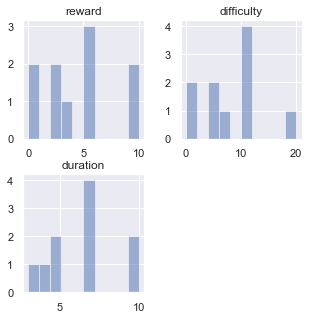

In [431]:
# Distribution of values within numeric fields
portfolio.hist(alpha=0.5, figsize=(5, 5));

#### Portfolio EDA: Observation(s)

1. The Portfolio data contains 10 unique records and 6 columns. 
2. There are no null values and data types include: int64 and objects.
3. There are 3 types of offers - bogo, Informational and discount.
4. Mode for reward, difficulty and duration values: 5, 10, 7.

#### Portfolio EDA: Action Point(s)

1. Create a new id column with more recognizable and easier to process values for offer id.
2. Duration (days) needs to be converted to hours which is the unit of measure for time in transcript dataset.

## 2.3 Profile Dataset
To Review: dataframe structure; data types; unique values; distribution

In [432]:
# View the dataframe and values
profile.head(3)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [433]:
# View data structure and types
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [434]:
# Null check: Count and % proportion
print('Null Check: Count')
print('-----------------')
print(profile.isnull().sum())
print('')
print('Null Check: % occurrance')
print('------------------------')
print(profile.isnull().mean())

Null Check: Count
-----------------
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Null Check: % occurrance
------------------------
gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64


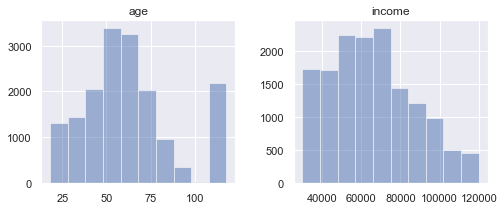

In [435]:
# Distribution of values within numeric fields
profile[['age','income']].hist(alpha=0.5, figsize=(8, 3));

In [436]:
# Understand categories within gender
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

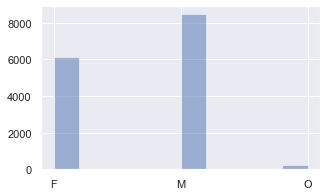

In [437]:
# Understand distribution of gender
profile['gender'].hist(alpha=0.5, figsize=(5, 3));

#### Profile EDA: Observation(s)

1. The Portfolio data contains 17,000 unique records and 5 columns. 
2. There are 2,175 null values in gender and income columns. The proportion of null values is 12.5% of dataset
3. Data types include: int64, object and null
4. Age column has an outlier value: 118.
5. Income distribution is right skewed
6. "became_member_on" column should be date and not integer 

#### Profile EDA: Action Point(s)
1. Create a short version of id (user_id).
2. Address null records: Keep (Impute) or Remove (Delete)
3. Attempt a correction for error in age (118). Most likely a data entry error for 18.
4. Convert "became_member_on" to datetype

## 2.4 Transcript Dataset
To Review: table structure; data types; unique values; distribution

In [438]:
# View the table structure and values
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [439]:
# View data structure and types
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [440]:
# Understand categories within event
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [441]:
# Highlight data structure within events column
transcript['value'].tail()

306529    {'amount': 1.5899999999999999}
306530                  {'amount': 9.53}
306531                  {'amount': 3.61}
306532    {'amount': 3.5300000000000002}
306533                  {'amount': 4.05}
Name: value, dtype: object

In [442]:
# Highlight data structure within events column
transcript['value'].head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [443]:
# Uniqueness check of person column
transcript['person'].nunique()

17000

#### Transcript EDA: Observation(s)
1. The Transcript data contains 306534 unique records and 4 columns. 
2. There are no null values in any columns.
3. Data types include: int64, object (incl. dictionary in value column)

#### Transcript EDA: Action Point(s)
1. Rename person column to user_id and map to profile user id (short version).
2. Unpack value column to extract key and values

<a id="data-pre-processing"></a>

[back to top menu](#toplevel)

# 3.0 Data Pre-processing
Within this section, data transformation requirements identified as action points within the Exploratory Data Analysis (EDA) section would be completed. Further data tranformation activities will be performed on relevant data in preparation for various analysis and machine learning models

## 3.1 Portfolio
- Create a new id column with more recognizable and easier to process values for offer id.
- Duration (days) needs to be converted to hours which is the unit of measure for time in transcript dataset.
- Create mapping files: short version id vs id; short id vs duration in hours

Create a new id column with more recognizable and easier to process values for offer id

In [444]:
# define rules
rule01 = lambda x:x[:4]
rule02 = lambda x:'0'+ str(x) if x<10 else str(x)
rule03 = lambda x:'0'+ str(x) if x<10 else str(x)

# apply to relevant columns within dataframe
portfolio['short_id'] = portfolio['offer_type'].apply(rule01) + portfolio['duration'].apply(rule02) + portfolio['difficulty'].apply(rule03)

In [445]:
# view impact on dataframe
portfolio.head(3)

,reward,channels,difficulty,duration,offer_type,id,short_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo0710
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo0510
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,info0400


Create a column for duration in hours

In [446]:
# set conversion of day to hours (24hrs = 1 day)
day_hrs = 24.0

# apply to relevant columns within dataframe
portfolio['duration_hrs'] = portfolio['duration'] * day_hrs

In [447]:
# view impact on dataframe
portfolio.head(3)

,reward,channels,difficulty,duration,offer_type,id,short_id,duration_hrs
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo0710,168.0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo0510,120.0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,info0400,96.0


Create Mapping Files: short version id vs id; short id vs duration in hours

In [448]:
# Map long offer id to new short id
map_id_shortid = dict(portfolio[['id','short_id']].values.tolist()) # map required to simplify data analysis

# Map new short id to duration (in hours)
map_shortid_hrs = dict(portfolio[['short_id','duration_hrs']].values.tolist()) # map is required for transcript data

Additional: Create list of offers to automate analysis of impact of offers on different customer segment categories

In [449]:
# generate list for portfolio.short_id column
offer_list_shortid = portfolio['short_id'].values.tolist()

# remove informational
offer_list_shortid.remove('info0300')
offer_list_shortid.remove('info0400')

# sort to group similiar offers
offer_list_shortid.sort()

## 3.2 Profile
- Create short version of id (user_id)
- Address null records: Keep (Impute) or Remove (Delete)
- Attempt a correction for error in age (118). Most likely a data entry error for 18
- Convert "became_member_on" to date

Create short version of id (user_id)

In [450]:
# Create short version of id (user_id)
def id_mapper():
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in profile['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

id_encoded = id_mapper()
profile['user_id'] = id_encoded

# show header
profile.head(3)

,gender,age,id,became_member_on,income,user_id
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,3


Address null records: Keep (Impute) or Remove (Delete)

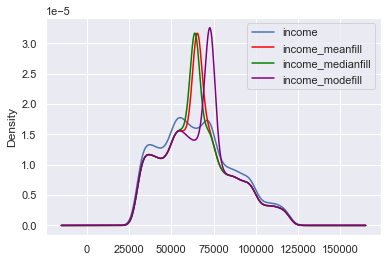

In [451]:
# Impute Numeric Fields: Fill nans with mean, median, mode
profile['income_meanfill'] = np.round(profile['income'].fillna(profile['income'].mean()),1)
profile['income_medianfill'] = np.round(profile['income'].fillna(profile['income'].median()),1)
profile['income_modefill'] = np.round(profile['income'].fillna(profile['income'].mode(dropna=True)[0]),1)

# Review impact on distribution (kde) and select most suitable option
fig = plt.figure() 
ax = fig.add_subplot(111) 
profile['income'].plot(kind='kde', ax=ax) 
profile['income_meanfill'].plot(kind='kde', ax=ax, color='red')
profile['income_medianfill'].plot(kind='kde', ax=ax, color='green') 
profile['income_modefill'].plot(kind='kde', ax=ax, color='purple') 
lines, labels = ax.get_legend_handles_labels() 
ax.legend(lines, labels, loc='best')
plt.show() 

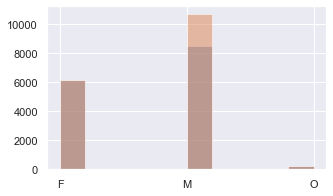

In [452]:
# Impute Categorical Fields: Fill nans mode
profile['gender-fill'] = profile['gender'].fillna(profile['gender'].mode()[0])

# Review impact on distribution (kde) and select most suitable option
profile['gender'].hist(alpha=0.5, figsize=(5, 3));
profile['gender-fill'].hist(alpha=0.5, figsize=(5, 3));

Attempt a correction for error in age (118). Most likely a data entry error for 18

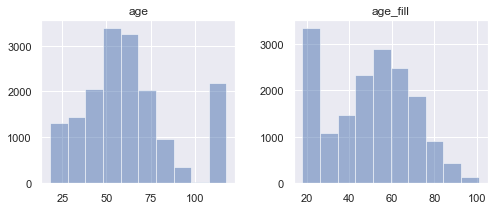

In [453]:
# Replace 118 with 18
profile['age_fill'] = profile['age'] # create new age column to use and preserve original data field
profile['age_fill'].replace(to_replace=118,value=18, inplace=True)
profile[['age','age_fill']].hist(alpha=0.5, figsize=(8, 3)); # plot histogram before and after change

Convert "became_member_on" to date

In [454]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

Additional Task: Create mapping for id, user_id

In [455]:
id_userid_map = profile[['id','user_id']]
map_userid_person = dict(id_userid_map.values.tolist()) # map required to simplify data analysis

### Profile Comments: Filling nulls vs Deleting nulls


**Background:**

New columns were created for columns with null values inorder to determine the impact of filling nulls. This approach also creates a fall-back in the event the option to delete nulls is considered.

**Observations:**

1. Median fill appears most suitable for income column as the underlying distribution is skewed (see density plots)
2. Replacing 118 with 18 has moved the outlier from the right to the left.

**Conclusion:**

Overall, the choice of either filling nulls or deleting will depend on the model selected for segmenting customers. The basis for segmentation ( customer behaviour, demographics, psycograhics etc.) will determine which features are relevant. For example, the choice of customer behaviour as basis for segmentation will not require the use income, age and sex columns which are are relevant in the demographics approach.

## 3.3 Transcript
- Unpack value column to extract key and values
- Apply unpacked value column to transcript dataframe
- Map person to profile user id (short version).

Unpack value column to extract keys and values

In [456]:
# Extract value column into dataframe
value_unpacked = pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index) 
value_unpacked['offerid'] = value_unpacked['offer id'].combine_first(value_unpacked['offer_id'])
value_unpacked.drop(['offer id','offer_id'],axis=1, inplace=True)
value_unpacked.head(3)

,amount,reward,offerid
0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,NaN,NaN,2906b810c7d4411798c6938adc9daaa5


Apply unpacked value column to transcript dataframe

In [457]:
# Applying unpacked value column to transcript dataframe
transcript_unpacked = pd.merge(pd.merge(transcript, value_unpacked, left_index=True, right_index=True),id_userid_map,how='left',left_on='person',right_on='id')  
transcript_unpacked.drop(['value'],axis=1, inplace=True)
transcript_unpacked.drop(['id'],axis=1, inplace=True)
transcript_unpacked.head(3)

,person,event,time,amount,reward,offerid,user_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,6


Map person to profile user id (short version).

In [458]:
# Map person to profile user id (short version).
transcript_unpacked['short_id'] = transcript_unpacked['offerid'].map(map_id_shortid)
transcript_unpacked['duration_hrs'] = transcript_unpacked['short_id'].map(map_shortid_hrs)
transcript_unpacked.fillna(0, inplace=True)
transcript_unpacked.head(5)

,person,event,time,amount,reward,offerid,user_id,short_id,duration_hrs
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,bogo0705,168.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,disc1020,240.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,6,disc0710,168.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,7,disc1010,240.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,8,bogo0510,120.0


<a id="analysis"></a>

[back to top menu](#toplevel)

# 4.0 Analysis
- Background information for context
- Transaction Labelling
- PCA (dimension reduction)
- K-means clustering

## 4.1 Background information for context

Key Ideas:

1. There are 2 states to customer behaviour: offer-induced ("excited") state and steady ("uninfluenced") state.


2. Categorizing customer transactions by influence type - bogo, discount, self - and establishing the relative contribution of each category provides a quantitative definition of individual customer preferences/behaviour (Transaction Labelling).


3. Transactions are said to be influenced by an offer when these transactions occur after a valid offer is received and viewed. In the event a transaction is completed before an offer is viewed, it is deemed to be uninfluenced (self). In addition, transactions completed outside the influence of any offer are deemed to be "uninfluenced" and labelled "self" (Transaction labelling)


4. Informationals do not influence transactions because these do not have a motivator/reward (assumption)


5. Customer behaviour can be used as a basis to segment customer base in addition to the use of demographic, psychograhic and other factors. There is a need to identify the most suitable factors (PCA and Clustering).


6. Count and value of transactions completed under the influence of an offer provide a measure of the impact of the offer. These measures can be reviewed at individual and segment levels (Impact of offer - incremental transactions and revenue)


## 4.2 Transaction Labelling

Data Preparation

In [459]:
# Creating new columns in preparation for transaction labelling
transcript_unpacked = transcript_unpacked.drop(columns=['person','offerid']) # dropping redundant columns to streamline
transcript_unpacked['influence'] = ''    # required to capture name of influencing offer
transcript_unpacked['completiontype'] = '' # required to identify offer completion which occur after offer view
transcript_unpacked['time_btw_offers'] = 0.0 # required to comment on frequency/volume of offers in test
transcript_unpacked['active_offers'] = '' # required to evaluate occurence and impact of multiple active offers

# Sort dataframe by userid and time to create blocks of user-specific, sequenced transactions
transcript_unpacked.sort_values(by=['user_id','time'], ascending=True, inplace=True)
transcript_unpacked.reset_index(inplace=True, drop=True)

Labelling Transactions

In [460]:
# Iterating through txn history (transcript) and labeling relevant fields
# ***********************************************************************

userid = "" # initializing user id which is necessary to track user transactions

# Looping through modified transcript dataframe to label transactions based on influencing offer

for index, row in transcript_unpacked.iterrows():
    
    if row['user_id'] == userid:
        
            if row['event'] == 'offer received':
                transcript_unpacked.at[index, 'time_btw_offers'] =  row['time'] - txntime # time between offers
        
                if ('info' in offerid) or ('info' in row['short_id']):
                    transcript_unpacked.at[index, 'active_offers'] = ''        
                else:
                    if (row['time'] - txntime) - offer_duration < 0: # remember to exclude info
                        if offercomplete == 0:
                            transcript_unpacked.at[index, 'active_offers'] = '2+'
        
                offerid = row['short_id'] 
                txntime = row['time']
                offer_duration = row['duration_hrs']
                offercomplete == 0
              
    
            if row['event'] == 'offer viewed':
                if row['short_id'] == offerid:
                    if ('info' in offerid):
                        influencedby = ""
                    else:
                        if row['time'] - txntime < offer_duration:
                            influencedby = offerid
                
            if row['event'] == 'transaction':
                if row['time'] - txntime < offer_duration: #transaction is within the period of an offer
                    if len(influencedby) != 0: #test to determine if offer has been viewed
                        transcript_unpacked.at[index, 'influence'] = influencedby
                    else:
                        transcript_unpacked.at[index, 'influence'] = 'self'
                else:
                    transcript_unpacked.at[index, 'influence'] = 'self'
    
    
            if row['event'] == 'offer completed':
                if row['short_id'] == offerid:
                    if len(influencedby) == 0: #test to determine if offer has been viewed
                        transcript_unpacked.at[index, 'completiontype'] = 'offer: not viewed'
                    else:
                        transcript_unpacked.at[index, 'completiontype'] = 'offer:viewed'
                    influencedby = ""
                    offercomplete = 1
    else:
        
        userid = row['user_id']
        offerid = "" 
        txntime = 0
        offer_duration = 0
        offercomplete = 0
        influencedby = ""
        
        
        if row['event'] == 'offer received':
            offerid = row['short_id'] 
            txntime = row['time']
            offer_duration = row['duration_hrs']
            offercomplete == 0

                
        if row['event'] == 'transaction':
            transcript_unpacked.at[index, 'influence'] = 'self'


In [461]:
# Displaying updates made (1st 10 records)
transcript_unpacked.head(10)

,event,time,amount,reward,user_id,short_id,duration_hrs,influence,completiontype,time_btw_offers,active_offers
0,offer received,168,0.00,0.0,1,disc0710,168.0,,,0.0,
1,offer viewed,216,0.00,0.0,1,disc0710,168.0,,,0.0,
2,offer received,336,0.00,0.0,1,disc1020,240.0,,,168.0,
3,offer viewed,348,0.00,0.0,1,disc1020,240.0,,,0.0,
4,transaction,360,0.35,0.0,1,0,0.0,disc1020,,0.0,
5,offer received,408,0.00,0.0,1,disc1010,240.0,,,72.0,2+
6,offer viewed,408,0.00,0.0,1,disc1010,240.0,,,0.0,
7,transaction,414,0.74,0.0,1,0,0.0,disc1010,,0.0,
8,transaction,444,1.89,0.0,1,0,0.0,disc1010,,0.0,
9,offer received,504,0.00,0.0,1,disc0707,168.0,,,96.0,2+


In [462]:
# Displaying updates made (last 10 records)
transcript_unpacked.tail(10)

,event,time,amount,reward,user_id,short_id,duration_hrs,influence,completiontype,time_btw_offers,active_offers
306524,transaction,84,25.19,0.0,17000,0,0.0,self,,0.0,
306525,transaction,96,21.53,0.0,17000,0,0.0,self,,0.0,
306526,offer received,336,0.00,0.0,17000,info0400,96.0,,,336.0,
306527,offer received,408,0.00,0.0,17000,bogo0505,120.0,,,72.0,
306528,transaction,480,30.57,0.0,17000,0,0.0,self,,0.0,
306529,offer completed,480,0.00,5.0,17000,bogo0505,120.0,,offer: not viewed,0.0,
306530,transaction,486,19.47,0.0,17000,0,0.0,self,,0.0,
306531,offer viewed,546,0.00,0.0,17000,bogo0505,120.0,,,0.0,
306532,offer received,576,0.00,0.0,17000,info0400,96.0,,,168.0,
306533,transaction,690,24.71,0.0,17000,0,0.0,self,,0.0,


customer-offer interaction matrix

In [463]:
# Create customer-offer interaction matrix (view into customer preferences/behaviour)

df_extract_txns = transcript_unpacked[transcript_unpacked.event=='transaction'] # extract transactions
cust_offer_matrix = df_extract_txns.groupby(by=['user_id','influence'])['amount'].sum().unstack() # matrix by spend
df_cust_offer_nonull = cust_offer_matrix.fillna(0) # create a copy of customer-offer interaction matrix and fill null
df_cust_offer_nonull.head(3)

influence,bogo0505,bogo0510,bogo0705,bogo0710,disc0707,disc0710,disc1010,disc1020,self
user_id,,,,,,,,,
1,0.0,0.0,0.00,0.0,7.54,0.0,12.51,0.35,0.00
2,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,77.01
3,0.0,0.0,2.14,0.0,0.00,0.0,0.00,0.00,12.16


Interpretation:
    
- user 1 is a bargain hunter who only purchases with discount offers. Preference is disc0710, disc1010 and disc1020
- user 2 is not influenced by bogo and discount offers. Self motivated
- user 3 is both self motivated and interested in bogo offers. Preference is bogo0705

In [464]:
# Identify customers with no transactions across self, bogo and discount

cust_with_txns = df_cust_offer_nonull.shape[0] # customers with at least 1 txn across self and offers
total_cust_base = transcript_unpacked.user_id.nunique() # total number of customers in sample

print("number of customers with at least 1 transaction: {:,}".format(cust_with_txns))
print("number of customers in sample: {:,}".format(total_cust_base))
print("number of customers without transactions: {:,}".format((total_cust_base-cust_with_txns)))

number of customers with at least 1 transaction: 16,578
number of customers in sample: 17,000
number of customers without transactions: 422


Comment(s):

There are 422 customers who neither responded to the offers nor performed any transaction within the test period. Their user ids are not captured in the user-offer matrix and their preferences are yet unknown. However, with the addition of relevant demographics-related columns from the profile dataframe to create a comprehensive reference table/dataframe, the customer user ids will reflect in the matrix (no nulls version) with 0 across offer/self columns


Additional tasks: Create a comprehensive reference dataframe by adding relevant columns to user-interaction dataframe

In [465]:
# Transaction count per customer
df_cust_txnCount = df_extract_txns[df_extract_txns.influence=='self'].groupby(['user_id']).agg(txn_count=('event',pd.Series.count)).reset_index()

In [466]:
# Profile dataframe: Create column for number of months as member
cutoff_date = pd.to_datetime('20210618',format='%Y%m%d')
profile['membership_mnths'] = ((cutoff_date - profile['became_member_on'])/np.timedelta64(1,'M')).astype(int)

In [467]:
# Profile dataframe: Extract relevant fields - userid, age, income (median fill), months as member
cust_profile_trim = profile[['user_id','age_fill','income_medianfill','membership_mnths','gender-fill']]

In [468]:
# join profile trim with count of transactions
cust_profile_txn = cust_profile_trim.merge(df_cust_txnCount, how='left', on='user_id')

In [469]:
# create master dataframe with demographics and customer-offer interaction details
cust_profile_txn_matrix = cust_profile_txn.merge(df_cust_offer_nonull, how='left',on='user_id')

In [470]:
# cleaning master dataframe
cust_profile_txn_matrix.set_index('user_id',drop=True,inplace=True) # set user_id as index
cust_profile_txn_matrix.fillna(0, inplace=True) # fill nulls

In [471]:
# Creating subtotals for bogo and discount offers
cust_profile_txn_matrix['bogo'] = (cust_profile_txn_matrix['bogo0505']
                                        +cust_profile_txn_matrix['bogo0510']
                                        +cust_profile_txn_matrix['bogo0705']
                                        +cust_profile_txn_matrix['bogo0710'])

cust_profile_txn_matrix['discount'] = (cust_profile_txn_matrix['disc0707']
                                            +cust_profile_txn_matrix['disc0710']
                                            +cust_profile_txn_matrix['disc1010']
                                            +cust_profile_txn_matrix['disc1020'])

In [472]:
# create categories for membership. Business rule (Assumption) - Members are new for 3 months after joining

membership_filter = lambda x: "new" if x <= 37 else "old" 
cust_profile_txn_matrix['custtype'] = cust_profile_txn_matrix['membership_mnths'].apply(membership_filter)

#comments: 
#********
#The latest membership date is 34 months from cutoff date. 34mnths + 3mnths (37) will filter out new members
# Choice of 3 months was based on optimization. 3 months returned highest silhouette score (0.7456) 
# compared to 6 (0.6881), 12 (0.6473) etc

In [473]:
# view master reference dataframe
cust_profile_txn_matrix.head(3)

,age_fill,income_medianfill,membership_mnths,gender-fill,txn_count,bogo0505,bogo0510,bogo0705,bogo0710,disc0707,disc0710,disc1010,disc1020,self,bogo,discount,custtype
user_id,,,,,,,,,,,,,,,,,
1,18,64000.0,52,M,0.0,0.0,0.0,0.00,0.0,7.54,0.0,12.51,0.35,0.00,0.00,20.4,old
2,55,112000.0,47,F,3.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,77.01,0.00,0.0,old
3,18,64000.0,35,M,5.0,0.0,0.0,2.14,0.0,0.00,0.0,0.00,0.00,12.16,2.14,0.0,new


In [474]:
# understand master reference dataframe
cust_profile_txn_matrix.describe()

,age_fill,income_medianfill,membership_mnths,txn_count,bogo0505,bogo0510,bogo0705,bogo0710,disc0707,disc0710,disc1010,disc1020,self,bogo,discount
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,49.737294,65225.235294,51.258294,4.420706,5.579786,5.756424,3.173905,6.106716,6.025166,3.475444,7.086873,2.950674,64.283364,20.616831,19.538156
std,20.280849,20174.747749,13.514806,3.590379,26.100266,23.705044,12.083894,23.235877,23.244991,16.823847,28.208737,20.385077,94.533591,43.909807,45.973108
min,18.000000,30000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,51000.000000,41.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.847500,0.000000,0.000000
50%,52.000000,64000.000000,46.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.400000,11.640000,9.590000
75%,65.000000,76000.000000,60.000000,6.000000,3.102500,3.130000,0.000000,3.045000,5.315000,0.000000,7.452500,0.000000,93.720000,27.355000,25.110000
max,101.000000,120000.000000,94.000000,32.000000,995.890000,1222.600000,689.800000,841.450000,1062.280000,779.230000,1033.780000,985.850000,1304.990000,1222.600000,1212.430000


# 4.2 PCA (Dimension Reduction)

In [475]:
cust_profile_txn_matrix.columns

Index(['age_fill', 'income_medianfill', 'membership_mnths', 'gender-fill',
       'txn_count', 'bogo0505', 'bogo0510', 'bogo0705', 'bogo0710', 'disc0707',
       'disc0710', 'disc1010', 'disc1020', 'self', 'bogo', 'discount',
       'custtype'],
      dtype='object')

The columns of the cust_profile_txn_matrix dataframe represent the different factors (features) which could be used to segment the sample customer base. The preferred factors would depend on:
- choice of basis for segmentation: demograhics, customer behaviour etc.
- relative strengths of individual factors as determined by PCA analysis

To facilitate decision making, 2 segmentation scenarios would be reviewed. Scenario 1 will review the use of demographic factors while Scenario 2 will explore the use of customer behavior related factors. Both will be reviewed and the most suitable scenario adopted for the rest of the analysis

Definitions

In [476]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [477]:
def showkeycomponents(df):
    X_std = StandardScaler().fit_transform(df.values)
    pca = PCA(n_components=0.90) # return components that explain 90% of variance in data
    principalComponents = pca.fit_transform(X_std)
    PCA_components = pd.DataFrame(principalComponents)
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_ratio_, color='black')
    plt.plot(features, pca.explained_variance_ratio_.cumsum(), color='blue', linestyle='--', marker ='o')
    plt.grid(True)
    return PCA_components 

In [478]:
def threeDplot(df):
    fig = plt.figure(figsize = (5, 5))
    ax = plt.axes(projection ="3d")
 
    # Creating plot
    ax.scatter3D(df[0],df[1],df[2], color = "black")
    plt.title("3D scatter plot")
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.view_init(30, 60)
 
    # show plot
    plt.show()
    return None    

One Hot Encoding for categorical Columns/Features

In [479]:
# transformation for gender and membership class
df_temp = pd.get_dummies((pd.get_dummies(cust_profile_txn_matrix, columns=['gender-fill'])), columns=['custtype'])

**SCENARIO 1: Segmentation Using Demograhics Data + Membership Class (Income, Age, Sex, Membership Type)**

In [480]:
# Features list and resulting dataframe
features_list = ['income_medianfill','age_fill','custtype_new','custtype_old','gender-fill_F','gender-fill_M','gender-fill_O']
df_cust_test = df_temp[features_list]

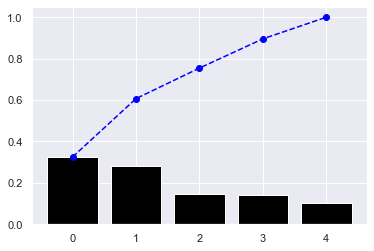

In [481]:
# Call PCA showkeycomponents
analysis_demographics = showkeycomponents(df_cust_test)

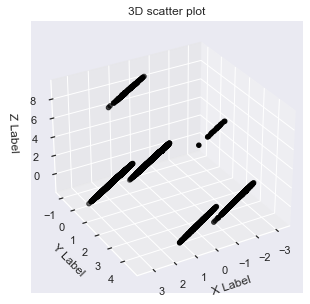

In [482]:
# 3D plot of top 3 components
threeDplot(analysis_demographics)

**SCENARIO 2: Segmentation Using Customer Bahaviour (Self, Bogo, Discount, Membership Class)**

In [483]:
# Features list and resulting dataframe
features_list =['self','bogo','discount','custtype_new','custtype_old']
df_cust_test = df_temp[features_list]

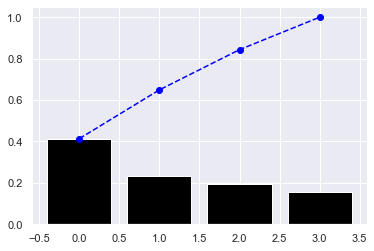

In [484]:
# Call PCA showkeycomponents
analysis_cust_behave = showkeycomponents(df_cust_test)

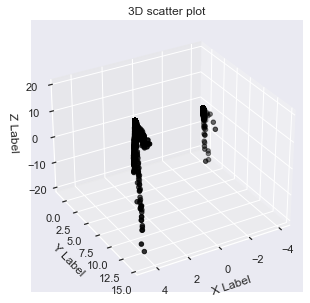

In [485]:
# 3D plot of top 3 components
threeDplot(analysis_cust_behave)

Comment(s):

Scenario 1
- requires 5 components to describe 90% of the variance in data
- 3D plot of top 3 components suggests the presence of distinct clusters

Scenario 2
- requires 4 components to describe 90% of the variance in data
- 3D plot of top 3 components suggests the presence of distinct clusters

# 4.3 K-means Clustering

Definitions

In [486]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [487]:
def normalize_data(df_to_normalize, no_of_components):
    scaler = MaxAbsScaler()
    scaler.fit(df_to_normalize)
    df_normalized = pd.DataFrame(scaler.transform(df_to_normalize), columns=df_to_normalize.columns)
    return df_normalized.iloc[:,:no_of_components]
    

In [488]:
def kmeans_cluster_no(df_normalized, components, max_no_cluster=20):
    wcss = []
    X = df_normalized.iloc[:,:components].values
    for i in range(1, max_no_cluster):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,max_no_cluster),wcss)
    plt.xlabel('number of clusters')
    plt.ylabel('wcss values')
    plt.title('The Elbow Method')
    plt.grid(True)
    plt.show()
    return None

In [489]:
def silhouette_cluster_no(df_normalized, max_no_cluster=10):
    
    range_n_clusters = list (range(2,max_no_cluster))
    cluster_scores = []
    
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters,init='k-means++', random_state=0)
        preds = clusterer.fit_predict(df_normalized)
        centers = clusterer.cluster_centers_
        score = silhouette_score(df_normalized, preds)
        
        cluster_scores.append(score)
        
        print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
    num_cluster = np.argmax(np.array(cluster_scores)) + 2
    print("Recommended number of clusters: {}".format(num_cluster))
    
    return num_cluster

In [490]:
def cluster_data(df_normalized, cluster_num):
    kmeansmodel = KMeans(n_clusters=cluster_num, init='k-means++', random_state=0)
    y_kmeans = kmeansmodel.fit_predict(df_normalized)
    kcategories = y_kmeans
    return kcategories

**SCENARIO 1: Segmentation Using Demograhics Data + Membership Class (Income, Age, Sex, Membership Type)**

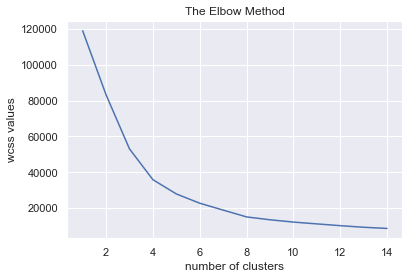

In [491]:
# Identify Number of Clusters: Elbow Method
kmeans_cluster_no(df_normalized=analysis_demographics,components=analysis_demographics.shape[1],max_no_cluster=15)

In [492]:
# Identify Number of Clusters: Silhouette Method
cluster_no_s1 = silhouette_cluster_no(df_normalized=analysis_demographics)

For n_clusters = 2, silhouette score is 0.4144721727282296)
For n_clusters = 3, silhouette score is 0.5013225354210914)
For n_clusters = 4, silhouette score is 0.5214749804502917)
For n_clusters = 5, silhouette score is 0.4590318820475061)
For n_clusters = 6, silhouette score is 0.43498282154814777)
For n_clusters = 7, silhouette score is 0.4548061337022208)
For n_clusters = 8, silhouette score is 0.46217059318096176)
For n_clusters = 9, silhouette score is 0.4491913152814559)
Recommended number of clusters: 4


**SCENARIO 2: Segmentation Using Customer Bahaviour (Self, Bogo, Discount, Membership Class)**

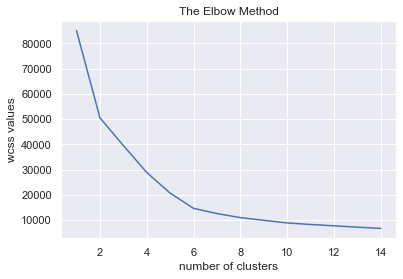

In [493]:
# Identify Number of Clusters: Elbow Method
kmeans_cluster_no(df_normalized=analysis_cust_behave,components=analysis_cust_behave.shape[1],max_no_cluster=15)

In [494]:
# Identify Number of Clusters: Silhouette Method
cluster_no_s2 = silhouette_cluster_no(df_normalized=analysis_cust_behave)

For n_clusters = 2, silhouette score is 0.7125152843614216)
For n_clusters = 3, silhouette score is 0.722488624591162)
For n_clusters = 4, silhouette score is 0.7323547442117891)
For n_clusters = 5, silhouette score is 0.7456155029082963)
For n_clusters = 6, silhouette score is 0.49032224240633265)
For n_clusters = 7, silhouette score is 0.493697623404042)
For n_clusters = 8, silhouette score is 0.5055823302030921)
For n_clusters = 9, silhouette score is 0.45528811365925625)
Recommended number of clusters: 5


**Segmentation: Demograhics vs Customer Behaviour**

- Both methods result in four (4)/five (5) clusters though customer behaviour has a higher silhouette score (0.7456) compared to demograhics (0.5214). By definition, the closer the score is to 1, the better.


- The use of demograhics data (age, income, sex etc.) required extensive data cleaning/manipulation to address for nulls. These impacted the underlying distribution of original data as well as accuracy of the clustering/segmentation task. In addition, the dependence on customers to provide these data is a weakness of this approach as changes in certain factors (income, sex etc.) is usually not communicated in real time or at all. Overall, the use of demographic data will create a static and most likely obsolete segmentation which might work for this test but would be unable to adapt quickly to changes in factors.


- The use of customer behaviour data addresses the concerns of using demographics data to segment. Willingness to spend and preferences are better factors for segmenting customers especially for profit-seeking businesses like Starbucks. In addition, data required is sourced from business systems and returns with no nulls. Most importantly, this approach is more responsive as changes in customer behaviour are inferred from transactions and eliminates need to depend on customers for key information.


- Finally, in the event of new customers who refuse to supply income/age/sex information, the demographics based model will fail while the customer behaviour based model will not as customer transactions will suffice.


**Conclusion**

Scenario 2 is the preferred solution and customer behaviour will be the basis for segmenting sample customer base

<a id="interpretation"></a>

# 5.0 Insights

[back to top menu](#toplevel)

# 5.1 Mapping users/customers to categories

In [495]:
# mapping users to categories

# cluster categories
cluster_category = cluster_data(df_normalized=analysis_cust_behave, cluster_num = cluster_no_s2)

# Assign to matrix
cust_profile_txn_matrix = df_temp
cust_profile_txn_matrix['category']=cluster_category
cust_profile_txn_matrix.head(3)

,age_fill,income_medianfill,membership_mnths,txn_count,bogo0505,bogo0510,bogo0705,bogo0710,disc0707,disc0710,...,disc1020,self,bogo,discount,gender-fill_F,gender-fill_M,gender-fill_O,custtype_new,custtype_old,category
user_id,,,,,,,,,,,,,,,,,,,,,
1,18,64000.0,52,0.0,0.0,0.0,0.00,0.0,7.54,0.0,...,0.35,0.00,0.00,20.4,0,1,0,0,1,0
2,55,112000.0,47,3.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,77.01,0.00,0.0,1,0,0,0,1,0
3,18,64000.0,35,5.0,0.0,0.0,2.14,0.0,0.00,0.0,...,0.00,12.16,2.14,0.0,0,1,0,1,0,1


## 5.2 Basic Cluster Characteristics

In [496]:
for cluster in range(cluster_no_s2):
    df_sample = cust_profile_txn_matrix[cust_profile_txn_matrix.category==cluster][features_list]
    key_par = ['count','min','mean','max']
    print("Summary: Cluster {}".format(cluster))
    print(round(df_sample.describe().loc[key_par],1))
    print("\n")

Summary: Cluster 0
          self     bogo  discount  custtype_new  custtype_old
count  14760.0  14760.0   14760.0       14760.0       14760.0
min        0.0      0.0       0.0           0.0           1.0
mean      60.5     19.6      18.2           0.0           1.0
max      358.8    326.2     332.0           0.0           1.0


Summary: Cluster 1
         self    bogo  discount  custtype_new  custtype_old
count  1920.0  1920.0    1920.0        1920.0        1920.0
min       0.0     0.0       0.0           1.0           0.0
mean     25.6    10.0      10.0           1.0           0.0
max     443.3   179.0     285.7           1.0           0.0


Summary: Cluster 2
        self  bogo  discount  custtype_new  custtype_old
count   57.0  57.0      57.0          57.0          57.0
min      0.0   0.0     346.0           0.0           0.0
mean   103.6  27.2     658.3           0.1           0.9
max    267.2  99.0    1212.4           1.0           1.0


Summary: Cluster 3
         self   bogo  d

**Explanation:**

- Category 0: Old customers with low average spend (sub 100) across self, bogo and discount.
- Category 1: New customers with low average spend (sub 100) across self, bogo and discount.
- Category 2: Customers (new and old) with high average spend (600 range) on Discount offers (clear preference for Discount).
- Category 3: Customers (new and old) with high average spend (600 range) on Self (not influenced by offers).
- Category 4: Customers (new and old) with high average spend (600 range) on BOGO (clear preference for BOGO).
- High Value Customers: Category 2, 3, 4
- Mass Market Customers: Category 0, 1

# 5.3 Offer Performance Within Categories

Data Processing for Analysis

In [497]:
#create mapping for userid and cluster category for use on transcript dataframe
userid = cust_profile_txn_matrix.index.values
category_no = cust_profile_txn_matrix.category.values
map_userid_catno = dict(zip(userid,category_no))

#labelling transactions performed by users in transcript with category values
transcript_unpacked['category'] = transcript_unpacked['user_id'].map(map_userid_catno)
transcript_unpacked.head(3)

,event,time,amount,reward,user_id,short_id,duration_hrs,influence,completiontype,time_btw_offers,active_offers,category
0,offer received,168,0.0,0.0,1,disc0710,168.0,,,0.0,,0
1,offer viewed,216,0.0,0.0,1,disc0710,168.0,,,0.0,,0
2,offer received,336,0.0,0.0,1,disc1020,240.0,,,168.0,,0


Defining Relevant Functions

In [498]:
def category_size(df=cust_profile_txn_matrix):
    df_temp_grp = df.groupby(['category'])['age_fill'].count()
    return df_temp_grp

In [499]:
def received_offer(offerid, txnhist=transcript_unpacked, event='offer received'):
    df_temp = txnhist[(txnhist['short_id']==offerid) & (txnhist['event']==event)]
    df_temp_grp = df_temp.groupby(['category'])['user_id'].count()
    return df_temp_grp

In [500]:
def viewd_offer(offerid, txnhist=transcript_unpacked, event='offer viewed'):
    df_temp = txnhist[(txnhist['short_id']==offerid) & (txnhist['event']==event)]
    df_temp_grp = df_temp.groupby(['category'])['user_id'].count()
    return df_temp_grp

In [501]:
def viewd_complete(offerid, txnhist=transcript_unpacked, event='offer:viewed'):
    df_temp = txnhist[(txnhist['short_id']==offerid) & (txnhist['completiontype']==event)]
    df_temp_grp = df_temp.groupby(['category'])['user_id'].count()
    return df_temp_grp

In [502]:
def no_txns(offerid, txnhist=transcript_unpacked, event='transaction'):
    df_temp = txnhist[(txnhist['influence']==offerid) & (txnhist['event']==event)]
    df_temp_grp = df_temp.groupby(['category'])['user_id'].count()
    return df_temp_grp

In [503]:
def txns_value(offerid, txnhist=transcript_unpacked, event='transaction'):
    df_temp = txnhist[(txnhist['influence']==offerid) & (txnhist['event']==event)]
    df_temp_grp = df_temp.groupby(['category'])['amount'].sum()
    return df_temp_grp

In [504]:
def cat_results(offer_short_id): 
    df_cat_size = pd.DataFrame(category_size())
    df_cat_size.rename(columns = {'age_fill':'cat_pop'},inplace=True)
    
    df_rec_offer = pd.DataFrame(received_offer(offer_short_id))
    df_rec_offer.rename(columns = {'user_id':'recv'},inplace=True)
    
    df_viewd_offer = pd.DataFrame(viewd_offer(offer_short_id))
    df_viewd_offer.rename(columns = {'user_id':'view'},inplace=True)
    
    df_viewd_complete = pd.DataFrame(viewd_complete(offer_short_id))
    df_viewd_complete.rename(columns = {'user_id':'compltn'},inplace=True)
    
    df_no_txns = pd.DataFrame(no_txns(offer_short_id))
    df_no_txns.rename(columns = {'user_id':'notxns'},inplace=True)
    
    df_txns_value = pd.DataFrame(txns_value(offer_short_id))
    df_txns_value.rename(columns = {'amount':'txnval'},inplace=True)  
    
    df_all = pd.concat([df_cat_size, df_rec_offer,df_viewd_offer,df_viewd_complete,df_no_txns,df_txns_value], axis=1)
    df_all['avgtxnval'] = round((df_all['txnval']/df_all['notxns']),2)
    df_all['%compltn'] = round(100*(df_all['compltn']/df_all['recv']),2)
    
       
    return df_all

In [505]:
print("Description for Performance Measures")
print("--------------------------")
print("cat_pop: number of customers in category")
print("recv: number of customers that received offer")
print("view: number of customers that viewed offer")
print("compltn: number of customers that completed offer after viewing")
print("notxns: number of transactions influenced by offer")
print("txnval: monetary value of transactions")
print("%compltn: percentage of customers who completed offer after viewing")

Description for Performance Measures
--------------------------
cat_pop: number of customers in category
recv: number of customers that received offer
view: number of customers that viewed offer
compltn: number of customers that completed offer after viewing
notxns: number of transactions influenced by offer
txnval: monetary value of transactions
%compltn: percentage of customers who completed offer after viewing


In [506]:
# Generate performance measures for offer across categories
for offer in offer_list_shortid:
    df_temp = cat_results(offer)
    print("category results for {}:".format(offer))
    print("------------------------------")
    print(df_temp)
    print("\n")

category results for bogo0505:
------------------------------
          cat_pop  recv  view  compltn  notxns    txnval  avgtxnval  %compltn
category                                                                     
0           14760  6563  6304     3146    7737  74856.13       9.68     47.94
1            1920   853   814      205     653   4909.77       7.52     24.03
2              57    15    15       11      13    320.44      24.65     73.33
3             208   100    93       66      91   1606.00      17.65     66.00
4              55    40    38       32      47  13164.03     280.09     80.00


category results for bogo0510:
------------------------------
          cat_pop  recv  view  compltn  notxns    txnval  avgtxnval  %compltn
category                                                                     
0           14760  6602  6345     2430    9122  80815.03       8.86     36.81
1            1920   839   805      139     716   4896.25       6.84     16.57
2              5

**General Trends**

- Offers which have difficulty value = duration are completed at higher rates than other offers. for example, bogo0505, disc0707, disc1010

- Low difficulty/short duration offers generate more incremental txn value as well as completion rates compared to high difficulty/long duration offers

- Value of transactions influenced by an offer is a better measure of performance than completion rates (see impact of mass market categories 0, 1 with relatively low completion rates but high number of small transactions and total transaction value).

**Category-Offer Ranking Table (Descending Order of Txv Value)**

- Category 0: disc1010; bogo0710; disc0707; bogo0510; bogo0505

- Category 1: disc1010; bogo0710; disc0707; bogo0505; bogo0510

- Category 2: disc1010; disc0707; disc1020; disc0710; bogo0710

- Category 3: disc1010; bogo0710; bogo0510; bogo0505; disc0707

- Category 4: bogo0505; bogo0510; bogo0710; bogo0705; disc1010   